
# **Mount Google Colab**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Dataset**

In [2]:
import os

# Replace 'path/to/dataset' with the actual path to your dataset on Google Drive
dataset_path = '/content/drive/MyDrive/Onize/new data clusters'

# List the activity folders
activities = os.listdir(dataset_path)

# Exploratory Data Analysis

Number of images in Leaving Kitchen: 197
Number of images in Pouring hot water: 261
Number of images in Make tea: 434
Number of images in Having Tea: 2326
Number of images in Entering Kitchen: 132


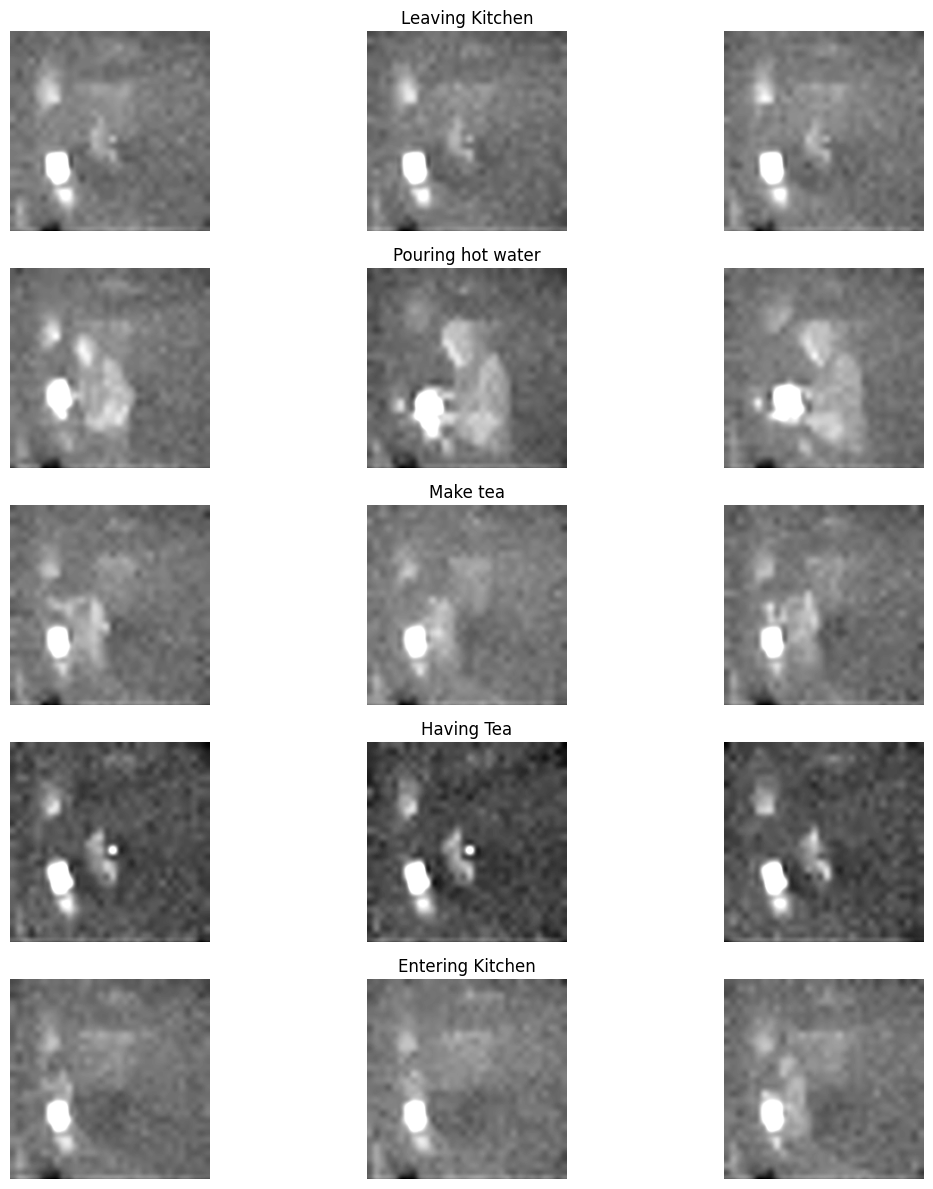

Dimensions of the first image in Leaving Kitchen: (224, 224)
Size of the first image in Leaving Kitchen (in bytes): 20742
Dimensions of the first image in Pouring hot water: (224, 224)
Size of the first image in Pouring hot water (in bytes): 21425
Dimensions of the first image in Make tea: (224, 224)
Size of the first image in Make tea (in bytes): 20754
Dimensions of the first image in Having Tea: (224, 224)
Size of the first image in Having Tea (in bytes): 21654
Dimensions of the first image in Entering Kitchen: (224, 224)
Size of the first image in Entering Kitchen (in bytes): 20390


In [3]:
import cv2
import matplotlib.pyplot as plt

# 1. Checking the number of images per activity
for activity in activities:
    activity_path = os.path.join(dataset_path, activity)
    print(f"Number of images in {activity}: {len(os.listdir(activity_path))}")

# 2. Displaying a few images from each category
fig, axarr = plt.subplots(len(activities), 3, figsize=(12, 12))

for idx, activity in enumerate(activities):
    activity_path = os.path.join(dataset_path, activity)
    images = os.listdir(activity_path)[:3]  # Get first 3 images
    for j, image_name in enumerate(images):
        image_path = os.path.join(activity_path, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        axarr[idx, j].imshow(img, cmap='gray')
        axarr[idx, j].axis('off')
        if j == 1:  # Label the middle column
            axarr[idx, j].set_title(activity)

plt.tight_layout()
plt.show()

# 3. Checking the dimensions and sizes of the images
for activity in activities:
    activity_path = os.path.join(dataset_path, activity)
    image_name = os.listdir(activity_path)[0]  # Just check the first image as an example
    image_path = os.path.join(activity_path, image_name)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    print(f"Dimensions of the first image in {activity}: {img.shape}")
    print(f"Size of the first image in {activity} (in bytes): {os.path.getsize(image_path)}")

# Data Preprocessing

In [4]:
! pip install tensorflow

In [7]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array

# List of activities
activities = ['Leaving Kitchen', 'Pouring hot water', 'Entering Kitchen',
              'Having Tea', 'Make tea']

data = []
labels = []

# Load and preprocess data
for idx, activity in enumerate(activities):
    activity_path = os.path.join(dataset_path, activity)

    for img_name in os.listdir(activity_path):
        img_path = os.path.join(activity_path, img_name)

        # Reading images
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resizing
        img = cv2.resize(img, (64, 64))

        data.append(img_to_array(img))
        labels.append(idx)

# Convert to numpy arrays and normalize the images
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)

# Split the data into 60% training, 20% validation, and 20% testing
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(activities))
y_val = to_categorical(y_val, num_classes=len(activities))
y_test = to_categorical(y_test, num_classes=len(activities))

# Feature extraction using a pre-trained CNN (VGG16 here)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
X_train_features = base_model.predict(X_train)
X_val_features = base_model.predict(X_val)

# Reshape the features in preparation for TGCN
# For this example, we're assuming each "sequence" is 5 images long
# Trim data to make it divisible by 5
num_sequences = len(X_train_features) // 5
X_train_features = X_train_features[:num_sequences*5]

# Reshape the features
X_train_features = X_train_features.reshape(-1, 5, *X_train_features.shape[1:])

# Trim validation data to make it divisible by 5
num_val_sequences = len(X_val_features) // 5
X_val_features = X_val_features[:num_val_sequences*5]

# Reshape the validation features
X_val_features = X_val_features.reshape(-1, 5, *X_val_features.shape[1:])

21/21 [==============================] - 36s 2s/step


## **Graph Construction**

In [8]:
!pip install networkx

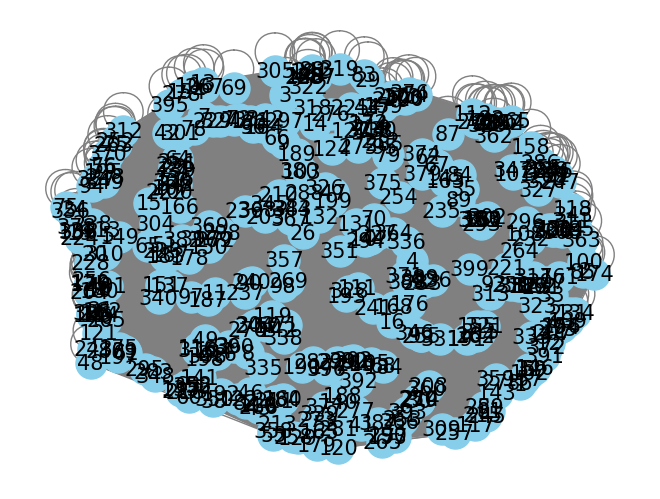

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

def compute_adjacency(features):
    # Compute the pairwise cosine similarities
    similarities = cosine_similarity(features.reshape(features.shape[0], -1))

    # Convert similarities to adjacency (using a threshold, e.g., 0.95)
    threshold = 0.95
    adjacency = (similarities > threshold).astype(int)

    return adjacency

def visualize_graph(adjacency):
    G = nx.Graph()
    for i in range(adjacency.shape[0]):
        for j in range(adjacency.shape[1]):
            if adjacency[i, j] == 1:
                G.add_edge(i, j)

    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=15)
    plt.show()


# Compute adjacency matrices
adjacency_train = compute_adjacency(X_train_features)
adjacency_val = compute_adjacency(X_val_features)

# Visualize training adjacency matrix (you can visualize others similarly)
visualize_graph(adjacency_train)

# Build T-GCN

In [10]:
import tensorflow as tf

class SpatioConvLayer(tf.keras.layers.Layer):
    def __init__(self, num_nodes, feature_dim, output_dim, order_of_chebyshev=2):
        super(SpatioConvLayer, self).__init__()
        self.num_nodes = num_nodes
        self.feature_dim = feature_dim
        self.output_dim = output_dim
        self.order_of_chebyshev = order_of_chebyshev

    def build(self, input_shape):
        # Weights for each order of adjacency matrix
        self.kernel = self.add_weight(name='kernel',
                                      shape=(self.order_of_chebyshev + 1, self.num_nodes, self.feature_dim, self.output_dim),
                                      initializer='uniform',
                                      trainable=True)

def call(self, features, adjacency):
    outputs = [features]
    batch_size, sequence_length, num_nodes, feature_dim = features.shape

    for k in range(self.order_of_chebyshev):
        # Modified multiplication to handle the feature_dim
        outputs.append(tf.einsum('ijkl,jklm->ijikm', outputs[-1], self.kernel[k]))

    return sum(outputs)

In [11]:
class TemporalConvLayer(tf.keras.layers.Layer):
    def __init__(self, output_dim, kernel_size):
        super(TemporalConvLayer, self).__init__()
        self.output_dim = output_dim
        self.kernel_size = kernel_size

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        self.kernel = self.add_weight(name='kernel',
                                      shape=(self.kernel_size, feature_dim, self.output_dim),
                                      initializer='uniform',
                                      trainable=True)

    def call(self, x):
        # x is of shape [batch_size, sequence_length, num_nodes, feature_dim]
        outputs = []
        sequence_length = x.shape[1]

        for t in range(sequence_length):
            temp_output = tf.matmul(x[:, t], self.kernel[0])
            for k in range(1, self.kernel_size):
                if t - k < 0:  # handle cases for t < k
                    break
                temp_output += tf.matmul(x[:, t - k], self.kernel[k])
            outputs.append(temp_output)

        return tf.stack(outputs, axis=1)

In [12]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

def build_TGCN(num_nodes, feature_dim, sequence_length, num_classes):
    input_features = Input(shape=(sequence_length, feature_dim))
    input_adjacency = Input(shape=(num_nodes, num_nodes))

    # Spatio Convolution
    spatio_conv = SpatioConvLayer(num_nodes=num_nodes, feature_dim=feature_dim, output_dim=16)
    x_spatio = spatio_conv(input_features, input_adjacency)

    # Temporal Convolution
    temporal_conv = TemporalConvLayer(16, kernel_size=3)
    x_temporal = temporal_conv(x_spatio)

    # Dense layer for prediction
    x = Flatten()(x_temporal)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=[input_features, input_adjacency], outputs=outputs)

## Model Compilation

In [13]:
tgcn_model = build_TGCN(num_nodes=5, feature_dim=2048, sequence_length=5, num_classes=len(activities))
tgcn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
tgcn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 2048)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 5, 5)]       0           []                               
                                                                                                  
 spatio_conv_layer (SpatioConvL  (None, 5, 2048)     491520      ['input_2[0][0]',                
 ayer)                                                            'input_3[0][0]']                
                                                                                                  
 temporal_conv_layer (TemporalC  (None, 5, 16)       98304       ['spatio_conv_layer[0][0]']  

# Train Model

In [15]:
print(X_train_features.shape)
print(adjacency_train.shape)
print(y_train.shape)

print(X_val_features.shape)
print(adjacency_val.shape)
print(y_val.shape)

(402, 5, 2, 2, 512)
(402, 402)
(2010, 5)
(134, 5, 2, 2, 512)
(134, 134)
(670, 5)


In [16]:
y_train = y_train[:402]
y_val = y_val[:134]

In [17]:
X_train_features = X_train_features.reshape((-1, 5, 2048))
X_val_features = X_val_features.reshape((-1, 5, 2048))

In [18]:
import numpy as np

# Suppose adj_matrix is your (5, 5) matrix
adj_matrix = np.random.rand(5, 5)

# Repeat this matrix for each sample in X_train_features
adjacency_train = np.tile(adj_matrix, (X_train_features.shape[0], 1, 1))
adjacency_val = np.tile(adj_matrix, (X_val_features.shape[0], 1, 1))

In [19]:
history = tgcn_model.fit([X_train_features, adjacency_train], y_train,
                         epochs=10,
                         batch_size=32,
                         validation_data=([X_val_features, adjacency_val], y_val))

Epoch 1/10


13/13 [==============================] - 4s 48ms/step - loss: 1.2137 - accuracy: 0.6940 - val_loss: 1.0811 - val_accuracy: 0.7090
Epoch 2/10
13/13 [==============================] - 0s 18ms/step - loss: 1.0488 - accuracy: 0.6940 - val_loss: 0.9815 - val_accuracy: 0.7090
Epoch 3/10
13/13 [==============================] - 0s 17ms/step - loss: 0.9970 - accuracy: 0.6965 - val_loss: 1.0192 - val_accuracy: 0.7090
Epoch 4/10
13/13 [==============================] - 0s 18ms/step - loss: 0.9637 - accuracy: 0.6965 - val_loss: 1.0032 - val_accuracy: 0.7090
Epoch 5/10
13/13 [==============================] - 0s 17ms/step - loss: 0.9274 - accuracy: 0.6990 - val_loss: 0.9776 - val_accuracy: 0.7090
Epoch 6/10
13/13 [==============================] - 0s 18ms/step - loss: 0.9105 - accuracy: 0.7114 - val_loss: 1.0448 - val_accuracy: 0.7090
Epoch 7/10
13/13 [==============================] - 0s 17ms/step - loss: 0.8928 - accuracy: 0.6965 - val_loss: 1.1363 - val_accuracy: 0.6866
Epoch 8/10
13/13 [======

# **Performance Evaluation**

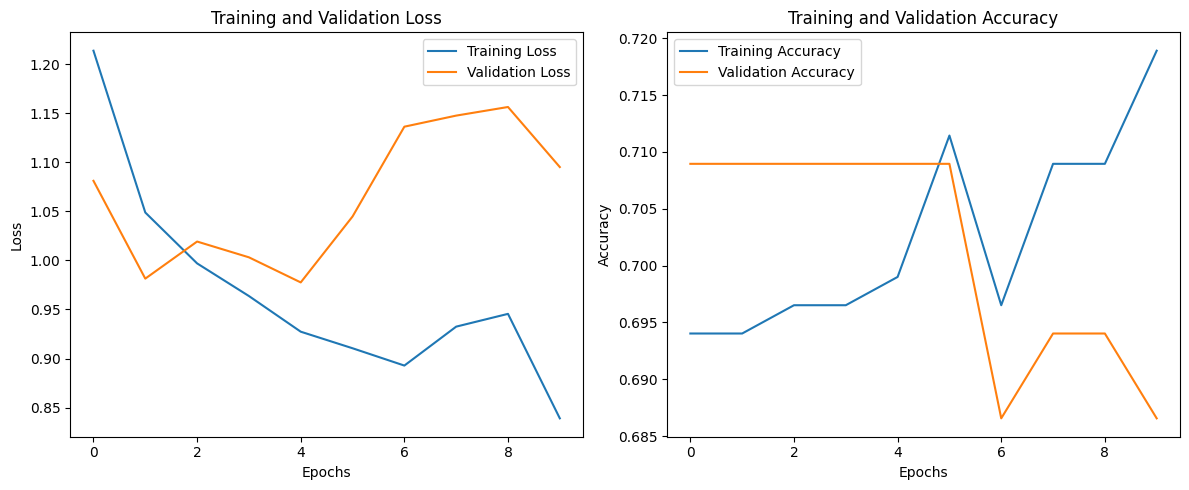

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Assuming you have your 'history' object from model.fit

# 1. Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 2. Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# 3. Evaluate on Test set
X_test_features = base_model.predict(X_test)  # extract features for test set

# Trim data to make it divisible by 5
num_test_sequences = len(X_test_features) // 5
X_test_features = X_test_features[:num_test_sequences*5]

# Reshape the features
X_test_features = X_test_features.reshape(-1, 5, *X_test_features.shape[1:])

21/21 [==============================] - 42s 2s/step


In [22]:
def create_identity_adjacency(num_nodes):
    return np.eye(num_nodes)

# Create identity adjacency matrix for test data
adjacency_test = np.array([create_identity_adjacency(5) for _ in range(X_test_features.shape[0])])


In [23]:
y_test = y_test[:num_test_sequences*5]
y_test = y_test.reshape(-1, 5, *y_test.shape[1:])

In [24]:
print(X_test_features.shape)
print(adjacency_test.shape)
print(y_test.shape)

(134, 5, 2, 2, 512)
(134, 5, 5)
(134, 5, 5)


In [25]:
y_test = y_test[:, -1, :]


In [26]:
X_test_features = X_test_features.reshape((-1, 5, 2048))

In [27]:
test_loss, test_acc = tgcn_model.evaluate([X_test_features, adjacency_test], y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

5/5 [==============================] - 0s 5ms/step - loss: 1.2086 - accuracy: 0.6194
Test Loss: 1.2086139917373657
Test Accuracy: 0.6194030046463013


5/5 [==============================] - 0s 5ms/step


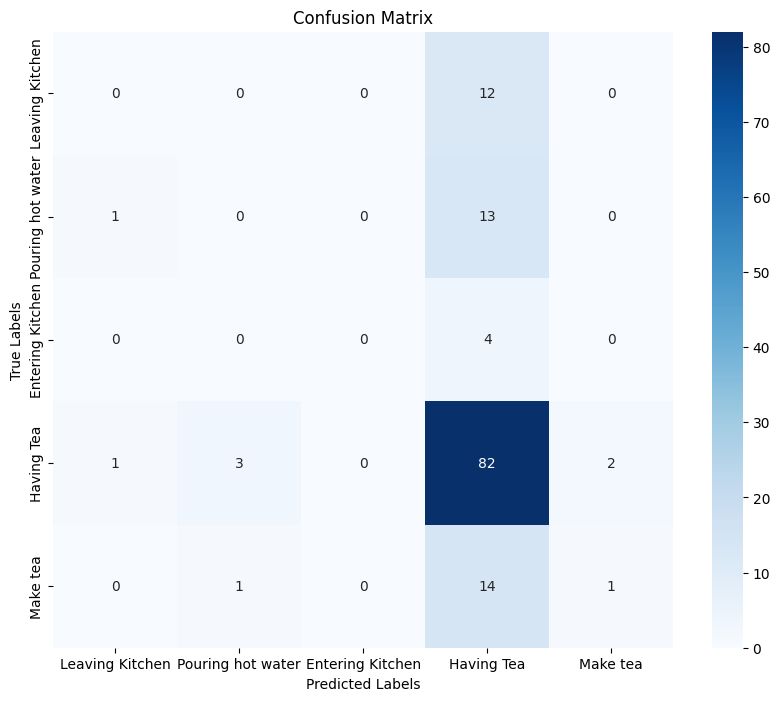

                   precision    recall  f1-score   support

  Leaving Kitchen       0.00      0.00      0.00        12
Pouring hot water       0.00      0.00      0.00        14
 Entering Kitchen       0.00      0.00      0.00         4
       Having Tea       0.66      0.93      0.77        88
         Make tea       0.33      0.06      0.11        16

         accuracy                           0.62       134
        macro avg       0.20      0.20      0.18       134
     weighted avg       0.47      0.62      0.52       134



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# 4. Plot Confusion Matrix
predictions = np.argmax(tgcn_model.predict([X_test_features, adjacency_test]), axis=1)
true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=activities,
            yticklabels=activities)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 5. Classification Report
report = classification_report(true_labels, predictions, target_names=activities)
print(report)